In [81]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import skgstat as skg
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [82]:
cwd = "c:\\Users\\m1865\\Desktop\\DISC"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed"

In [83]:
# Site Name
site_Name = "ATLAS-Mohammed V"

In [84]:
# Constant! 
g = 4.66

# 100m and 150m variogram, RAW Score and ST Score

In [85]:
img_100 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 100m.tif")
band_100 = img_100.read(1)
band_100.shape

(11, 11)

In [86]:
img_150 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 150m.tif")
band_150 = img_150.read(1)
band_150.shape

(15, 15)

In [87]:
# reshape the band arrays into one-dimensional array
band_100_reshape = band_100.reshape(-1)
band_150_reshape = band_150.reshape(-1)

In [88]:
# Get the coordinates n-dimensional array
list_Coordinates_100 = []
for x in range(img_100.shape[0]):
    for y in range(img_100.shape[1]):
        temp_x, temp_y = img_100.xy(x, y)
        temp_list = [temp_x, temp_y]
        list_Coordinates_100.append(temp_list)
arr_Coordinates_100 = np.array(list_Coordinates_100)
arr_Coordinates_100.shape

(121, 2)

In [89]:
# Get the coordinates n-dimensional array
list_Coordinates_150 = []
for x in range(img_150.shape[0]):
    for y in range(img_150.shape[1]):
        temp_x, temp_y = img_150.xy(x, y)
        temp_list = [temp_x, temp_y]
        list_Coordinates_150.append(temp_list)
arr_Coordinates_150 = np.array(list_Coordinates_150)
arr_Coordinates_150.shape

(225, 2)

In [90]:
# Get the maximum lag
diagonal_100 = 100 * (2 ** 0.5) / 2
bin_100 = np.arange(10,diagonal_100,10)
bin_100[-1]

70.0

In [91]:
# Get the maximum lag
diagonal_150 = 150 * (2 ** 0.5) / 2
bin_150 = np.arange(10,diagonal_150,10)
bin_150[-1]

100.0

## Variogram

In [92]:
V_100 = skg.Variogram(arr_Coordinates_100, band_100_reshape, use_nugget=True, bin_func=bin_100, maxlag = bin_100[-1])
V_100.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 4899.999999999999,
 'normalized_sill': 469.05320513600867,
 'normalized_nugget': 1.337260108581011e-13,
 'effective_range': 69.99999999999999,
 'sill': 21.40289332194311,
 'nugget': 6.101916612924605e-15,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'custom_bin_edges',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': 70.0,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

In [93]:
V_150 = skg.Variogram(arr_Coordinates_150, band_150_reshape, use_nugget=True, bin_func=bin_150, maxlag = bin_150[-1])
V_150.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 7413.463726419073,
 'normalized_sill': 519.2691276351802,
 'normalized_nugget': 4.282936711746578e-12,
 'effective_range': 74.13463726419073,
 'sill': 22.626452957649597,
 'nugget': 1.866231995540629e-13,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'custom_bin_edges',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': 100.0,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

### Variogram Plot

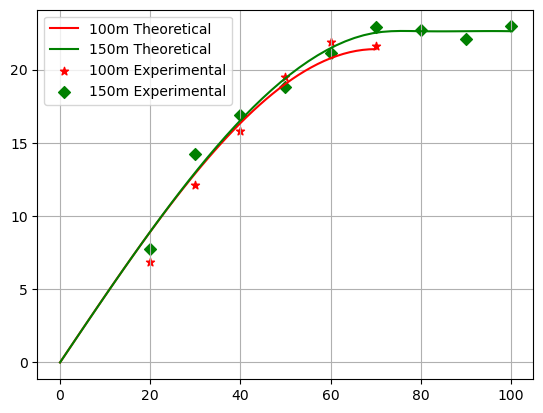

In [94]:
# Get the theoretical functions
def f_100(x):
   return V_100.fitted_model(x)
def f_150(x):
   return V_150.fitted_model(x)
# Create cubic interpolation model in order to make curved plot (otherwise it will be ugly af)
cubic_model_100 = interp1d(np.concatenate((np.array([0]),bin_100)), f_100(np.concatenate((np.array([0]),bin_100)),), kind = "cubic")
cubic_model_150 = interp1d(np.concatenate((np.array([0]),bin_150)), f_150(np.concatenate((np.array([0]),bin_150)),), kind = "cubic")
x_100 = np.linspace(0,bin_100[-1])
x_150 = np.linspace(0,bin_150[-1])
# Plot! 
plt.plot(x_100, cubic_model_100(x_100),label = '100m Theoretical', color = 'Red')
plt.plot(x_150, cubic_model_150(x_150), label = '150m Theoretical', color = 'Green')
plt.scatter(V_100.get_empirical()[0],V_100.get_empirical()[1], color = 'Red', label = '100m Experimental', marker = '*')
plt.scatter(V_150.get_empirical()[0],V_150.get_empirical()[1], color = 'Green', label = '150m Experimental', marker = 'D')
# plt.xlim(0,1)
# plt.ylim(0,0.15)
plt.legend()
plt.grid()

### Variogram Parameters

In [95]:
range_100 = V_100.parameters[0]
sill_100 = V_100.parameters[1] + V_100.parameters[2]
nugget_100 = V_100.parameters[2]
range_150 = V_150.parameters[0]
sill_150 = V_150.parameters[1] + V_150.parameters[2]
nugget_150 = V_150.parameters[2]
print("100m Range: " + str(range_100) + "; Sill: " + str(sill_100) + "; Nugget: " + str(nugget_100))
print("150m Range: " + str(range_150) + "; Sill: " + str(sill_150) + "; Nugget: " + str(nugget_150))

100m Range: 69.99999999999999; Sill: 21.402893321943118; Nugget: 6.101916612924605e-15
150m Range: 74.13463726419073; Sill: 22.626452957649786; Nugget: 1.866231995540629e-13


## Roman Metrics

### Rcv (Coefficient of Variation)

In [96]:
CV_100 = np.std(band_100) / np.mean(band_100)
CV_150 = np.std(band_150) / np.mean(band_150)
Rcv_100 = (CV_150 - CV_100) / CV_100
Rcv_100

0.08860069920145175

### RAW Score

In [97]:
RAW_100 = (abs(2 * Rcv_100)) ** (-1)
RAW_100

5.643296322788019

### Rse (Scale Requirement)

In [98]:
Rse_100 = math.exp(-((g / range_100) ** 2 + (g / range_150) ** 2) ** (1/2))
Rse_100

0.9125079298626493

### Rst (Spatial Correlation)

In [99]:
# Get the index of the range in the bin
for i in range(len(V_100.bins)):
    if range_100 >= V_100.bins[i] and range_100 <= V_100.bins[i+1]:
        index_100 = i + 1
estimator_Range_100 = V_100.experimental[index_100]
print(f"The range {(range_100)} falls in {V_100.bins[index_100 - 1]} and {V_100.bins[index_100]}, whose value is {estimator_Range_100}")
for i in range(len(V_150.bins)):
    if range_150 >= V_150.bins[i] and range_150 <= V_150.bins[i+1]:
        index_150 = i + 1
estimator_Range_150 = V_150.experimental[index_150]
print(f"The range {(range_150)} falls in {V_150.bins[index_150 - 1]} and {V_150.bins[index_150]}, whose value is {estimator_Range_150}")

The range 69.99999999999999 falls in 60.0 and 70.0, whose value is 21.614908454116616
The range 74.13463726419073 falls in 70.0 and 80.0, whose value is 22.733122835962003


In [100]:
ST_100 = (estimator_Range_100 - nugget_100) / estimator_Range_100
ST_150 = (estimator_Range_150 - nugget_150) / estimator_Range_150
Rst_100 = (ST_150 - ST_100) / ST_100
Rst_100

-7.99360577730113e-15

### Rsv Structural Variability

In [101]:
from scipy.integrate import quad

In [102]:
def f_100_SV(x):
    return (V_100.fitted_model(x) - nugget_100) / sill_100
def f_150_SV(x):
    return (V_150.fitted_model(x) - nugget_150) / sill_150
SV_100 = quad(f_100_SV, 0, range_100)[0]
SV_150 = quad(f_150_SV, 0, range_150)[0]
Rsv_100 = (SV_150 - SV_100) / SV_100
Rsv_100

0.05906624663128763

### ST Score

In [103]:
ST_Score_100 = (abs(Rcv_100) / 3 + abs(Rst_100) / 3 + abs(Rsv_100) / 3 +Rse_100) ** (-1)
ST_Score_100

1.0397926082216413

# 300m and 450m variogram, RAW Score and ST Score

In [104]:
img_300 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 300m.tif")
band_300 = img_300.read(1)
band_300.shape

(31, 31)

In [105]:
img_450 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 450m.tif")
band_450 = img_450.read(1)
band_450.shape

(45, 45)

In [106]:
# reshape the band arrays into one-dimensional array
band_300_reshape = band_300.reshape(-1)
band_450_reshape = band_450.reshape(-1)

In [107]:
# Get the coordinates n-dimensional array
list_Coordinates_300 = []
for x in range(img_300.shape[0]):
    for y in range(img_300.shape[1]):
        temp_x, temp_y = img_300.xy(x, y)
        temp_list = [temp_x, temp_y]
        list_Coordinates_300.append(temp_list)
arr_Coordinates_300 = np.array(list_Coordinates_300)
arr_Coordinates_300.shape

(961, 2)

In [108]:
# Get the coordinates n-dimensional array
list_Coordinates_450 = []
for x in range(img_450.shape[0]):
    for y in range(img_450.shape[1]):
        temp_x, temp_y = img_450.xy(x, y)
        temp_list = [temp_x, temp_y]
        list_Coordinates_450.append(temp_list)
arr_Coordinates_450 = np.array(list_Coordinates_450)
arr_Coordinates_450.shape

(2025, 2)

In [109]:
# Get the maximum lag
diagonal_300 = 300 * (2 ** 0.5) / 2
bin_300 = np.arange(10,diagonal_300,10)
bin_300[-1]

210.0

In [110]:
# Get the maximum lag
diagonal_450 = 450 * (2 ** 0.5) / 2
bin_450 = np.arange(10,diagonal_450,10)
bin_450[-1]

310.0

## Variogram

In [111]:
V_300 = skg.Variogram(arr_Coordinates_300, band_300_reshape, use_nugget=True, bin_func=bin_300, maxlag = bin_300[-1])
V_300.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 35277.36277247382,
 'normalized_sill': 8891.115418308511,
 'normalized_nugget': 2523.314175985102,
 'effective_range': 167.98744177368485,
 'sill': 81.15225467898922,
 'nugget': 23.031152449441915,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'custom_bin_edges',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': 210.0,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

In [112]:
V_450 = skg.Variogram(arr_Coordinates_450, band_450_reshape, use_nugget=True, bin_func=bin_450, maxlag = bin_450[-1])
V_450.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 24628.87265698885,
 'normalized_sill': 16294.043554007094,
 'normalized_nugget': 5.331719107736611e-12,
 'effective_range': 79.44797631286725,
 'sill': 123.97826492935467,
 'nugget': 4.056803223072962e-14,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'custom_bin_edges',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': 310.0,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

### Variogram Plot

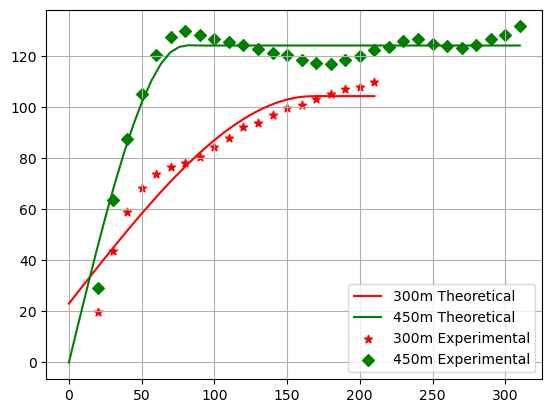

In [113]:
# Get the theoretical functions
def f_300(x):
   return V_300.fitted_model(x)
def f_450(x):
   return V_450.fitted_model(x)
# Create cubic interpolation model in order to make curved plot (otherwise it will be ugly af)
cubic_model_300 = interp1d(np.concatenate((np.array([0]),bin_300)), f_300(np.concatenate((np.array([0]),bin_300)),), kind = "cubic")
cubic_model_450 = interp1d(np.concatenate((np.array([0]),bin_450)), f_450(np.concatenate((np.array([0]),bin_450)),), kind = "cubic")
x_300 = np.linspace(0,bin_300[-1])
x_450 = np.linspace(0,bin_450[-1])
# Plot! 
plt.plot(x_300, cubic_model_300(x_300),label = '300m Theoretical', color = 'Red')
plt.plot(x_450, cubic_model_450(x_450), label = '450m Theoretical', color = 'Green')
plt.scatter(V_300.get_empirical()[0],V_300.get_empirical()[1], color = 'Red', label = '300m Experimental', marker = '*')
plt.scatter(V_450.get_empirical()[0],V_450.get_empirical()[1], color = 'Green', label = '450m Experimental', marker = 'D')
plt.legend()
plt.grid()

### Variogram Parameters

In [114]:
range_300 = V_300.parameters[0]
sill_300 = V_300.parameters[1] + V_300.parameters[2]
nugget_300 = V_300.parameters[2]
range_450 = V_450.parameters[0]
sill_450 = V_450.parameters[1] + V_450.parameters[2]
nugget_450 = V_450.parameters[2]
print("300m Range: " + str(range_300) + "; Sill: " + str(sill_300) + "; Nugget: " + str(nugget_300))
print("450m Range: " + str(range_450) + "; Sill: " + str(sill_450) + "; Nugget: " + str(nugget_450))

300m Range: 167.98744177368485; Sill: 104.18340712843114; Nugget: 23.031152449441915
450m Range: 79.44797631286725; Sill: 123.97826492935471; Nugget: 4.056803223072962e-14


## Roman Metrics

### Rcv (Coefficient of Variation)

In [115]:
CV_300 = np.std(band_300) / np.mean(band_300)
CV_450 = np.std(band_450) / np.mean(band_450)
Rcv_300 = (CV_450 - CV_300) / CV_300
Rcv_300

0.1417081979184895

### RAW Score

In [116]:
RAW_300 = (abs(2 * Rcv_300)) ** (-1)
RAW_300

3.528377379321413

### Rse (Scale Requirement)

In [117]:
Rse_300 = math.exp(-((g / range_300) ** 2 + (g / range_450) ** 2) ** (1/2))
Rse_300

0.9371764478820159

### Rst (Spatial Correlation)

In [118]:
# Get the index of the range in the bin
for i in range(len(V_300.bins)):
    if range_300 >= V_300.bins[i] and range_300 <= V_300.bins[i+1]:
        index_300 = i + 1
estimator_Range_300 = V_300.experimental[index_300]
print(f"The range {(range_300)} falls in {V_300.bins[index_300 - 1]} and {V_300.bins[index_300]}, whose value is {estimator_Range_300}")
for i in range(len(V_450.bins)):
    if range_450 >= V_450.bins[i] and range_450 <= V_450.bins[i+1]:
        index_450 = i + 1
estimator_Range_450 = V_450.experimental[index_450]
print(f"The range {(range_450)} falls in {V_450.bins[index_450 - 1]} and {V_450.bins[index_450]}, whose value is {estimator_Range_450}")

The range 167.98744177368485 falls in 160.0 and 170.0, whose value is 102.99354884108034
The range 79.44797631286725 falls in 70.0 and 80.0, whose value is 129.73493081349608


In [119]:
ST_300 = (estimator_Range_300 - nugget_300) / estimator_Range_300
ST_450 = (estimator_Range_450 - nugget_450) / estimator_Range_450
Rst_300 = (ST_450 - ST_300) / ST_300
Rst_300

0.28802479026066596

### Rsv Structural Variability

In [120]:
def f_300_SV(x):
    return (V_300.fitted_model(x) - nugget_300) / sill_300
def f_450_SV(x):
    return (V_450.fitted_model(x) - nugget_450) / sill_450
SV_300 = quad(f_300_SV, 0, range_300)[0]
SV_450 = quad(f_450_SV, 0, range_450)[0]
Rsv_300 = (SV_450 - SV_300) / SV_300
Rsv_300

-0.39283883074266507

### ST Score

In [121]:
ST_Score_300 = (abs(Rcv_300) / 3 + abs(Rst_300) / 3 + abs(Rsv_300) / 3 +Rse_300) ** (-1)
ST_Score_300

0.8255136183056031

# 900m and 1350m variogram, RAW Score and ST Score

In [122]:
img_900 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 900m.tif")
band_900 = img_900.read(1)
band_900.shape

(91, 91)

In [123]:
img_1350 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 1350m.tif")
band_1350 = img_1350.read(1)
band_1350.shape

(135, 135)

In [124]:
# reshape the band arrays into one-dimensional array
band_900_reshape = band_900.reshape(-1)
band_1350_reshape = band_1350.reshape(-1)

In [125]:
# Get the coordinates n-dimensional array
list_Coordinates_900 = []
for x in range(img_900.shape[0]):
    for y in range(img_900.shape[1]):
        temp_x, temp_y = img_900.xy(x, y)
        temp_list = [temp_x, temp_y]
        list_Coordinates_900.append(temp_list)
arr_Coordinates_900 = np.array(list_Coordinates_900)
arr_Coordinates_900.shape

(8281, 2)

In [126]:
# Get the coordinates n-dimensional array
list_Coordinates_1350 = []
for x in range(img_1350.shape[0]):
    for y in range(img_1350.shape[1]):
        temp_x, temp_y = img_1350.xy(x, y)
        temp_list = [temp_x, temp_y]
        list_Coordinates_1350.append(temp_list)
arr_Coordinates_1350 = np.array(list_Coordinates_1350)
arr_Coordinates_1350.shape

(18225, 2)

In [127]:
# Get the maximum lag
diagonal_900 = 900 * (2 ** 0.5) / 2
bin_900 = np.arange(10,diagonal_900,10)
bin_900[-1]

630.0

In [128]:
# Get the maximum lag
diagonal_1350 = 1350 * (2 ** 0.5) / 2
bin_1350 = np.arange(10,diagonal_1350,10)
bin_1350[-1]

950.0

## Variogram

In [129]:
V_900 = skg.Variogram(arr_Coordinates_900, band_900_reshape, use_nugget=True, bin_func=bin_900, maxlag = bin_900[-1])
V_900.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 98785.57558266725,
 'normalized_sill': 28452.86294914158,
 'normalized_nugget': 3277.3634243286774,
 'effective_range': 156.80250092486867,
 'sill': 153.21893456301007,
 'nugget': 17.64863286162098,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'custom_bin_edges',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': 630.0,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

In [130]:
V_1350 = skg.Variogram(arr_Coordinates_1350, band_1350_reshape, use_nugget=True, bin_func=bin_1350, maxlag = bin_1350[-1])
V_1350.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 224616.97546597212,
 'normalized_sill': 35508.860295153165,
 'normalized_nugget': 9429.206533221783,
 'effective_range': 236.43892154312854,
 'sill': 160.42838278898185,
 'nugget': 42.60098303731118,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'custom_bin_edges',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': 950.0,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

### Variogram Plot

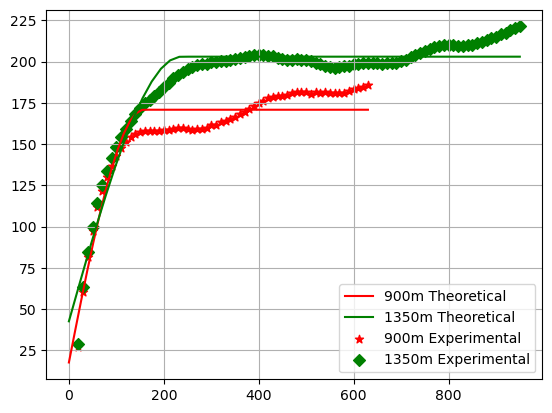

In [131]:
# Get the theoretical functions
def f_900(x):
   return V_900.fitted_model(x)
def f_1350(x):
   return V_1350.fitted_model(x)
# Create cubic interpolation model in order to make curved plot (otherwise it will be ugly af)
cubic_model_900 = interp1d(np.concatenate((np.array([0]),bin_900)), f_900(np.concatenate((np.array([0]),bin_900)),), kind = "cubic")
cubic_model_1350 = interp1d(np.concatenate((np.array([0]),bin_1350)), f_1350(np.concatenate((np.array([0]),bin_1350)),), kind = "cubic")
x_900 = np.linspace(0,bin_900[-1])
x_1350 = np.linspace(0,bin_1350[-1])
# Plot! 
plt.plot(x_900, cubic_model_900(x_900),label = '900m Theoretical', color = 'Red')
plt.plot(x_1350, cubic_model_1350(x_1350), label = '1350m Theoretical', color = 'Green')
plt.scatter(V_900.get_empirical()[0],V_900.get_empirical()[1], color = 'Red', label = '900m Experimental', marker = '*')
plt.scatter(V_1350.get_empirical()[0],V_1350.get_empirical()[1], color = 'Green', label = '1350m Experimental', marker = 'D')
plt.legend()
plt.grid()

### Variogram Parameters

In [132]:
range_900 = V_900.parameters[0]
sill_900 = V_900.parameters[1] + V_900.parameters[2]
nugget_900 = V_900.parameters[2]
range_1350 = V_1350.parameters[0]
sill_1350 = V_1350.parameters[1] + V_1350.parameters[2]
nugget_1350 = V_1350.parameters[2]
print("900m Range: " + str(range_900) + "; Sill: " + str(sill_900) + "; Nugget: " + str(nugget_900))
print("1350m Range: " + str(range_1350) + "; Sill: " + str(sill_1350) + "; Nugget: " + str(nugget_1350))

900m Range: 156.80250092486867; Sill: 170.86756742463103; Nugget: 17.64863286162098
1350m Range: 236.43892154312854; Sill: 203.02936582629303; Nugget: 42.60098303731118


## Roman Metrics

### Rcv (Coefficient of Variation)

In [133]:
CV_900 = np.std(band_900) / np.mean(band_900)
CV_1350 = np.std(band_1350) / np.mean(band_1350)
Rcv_900 = (CV_1350 - CV_900) / CV_900
Rcv_900

0.14158655526855585

### RAW Score

In [134]:
RAW_900 = (abs(2 * Rcv_900)) ** (-1)
RAW_900

3.5314087488859345

### Rse (Scale Requirement)

In [135]:
Rse_900 = math.exp(-((g / range_900) ** 2 + (g / range_1350) ** 2) ** (1/2))
Rse_900

0.9649679598439156

### Rst (Spatial Correlation)

In [136]:
# Get the index of the range in the bin
for i in range(len(V_900.bins)):
    if range_900 >= V_900.bins[i] and range_900 <= V_900.bins[i+1]:
        index_900 = i + 1
estimator_Range_900 = V_900.experimental[index_900]
print(f"The range {(range_900)} falls in {V_900.bins[index_900 - 1]} and {V_900.bins[index_900]}, whose value is {estimator_Range_900}")
for i in range(len(V_1350.bins)):
    if range_1350 >= V_1350.bins[i] and range_1350 <= V_1350.bins[i+1]:
        index_1350 = i + 1
estimator_Range_1350 = V_1350.experimental[index_1350]
print(f"The range {(range_1350)} falls in {V_1350.bins[index_1350 - 1]} and {V_1350.bins[index_1350]}, whose value is {estimator_Range_1350}")

The range 156.80250092486867 falls in 150.0 and 160.0, whose value is 157.84810644249538
The range 236.43892154312854 falls in 230.0 and 240.0, whose value is 193.5915490553885


In [137]:
ST_900 = (estimator_Range_900 - nugget_900) / estimator_Range_900
ST_1350 = (estimator_Range_1350 - nugget_1350) / estimator_Range_1350
Rst_900 = (ST_1350 - ST_900) / ST_900
Rst_900

-0.1218748581942494

### Rsv Structural Variability

In [138]:
def f_900_SV(x):
    return (V_900.fitted_model(x) - nugget_900) / sill_900
def f_1350_SV(x):
    return (V_1350.fitted_model(x) - nugget_1350) / sill_1350
SV_900 = quad(f_900_SV, 0, range_900)[0]
SV_1350 = quad(f_1350_SV, 0, range_1350)[0]
Rsv_900 = (SV_1350 - SV_900) / SV_900
Rsv_900

0.3287262979907404

### ST Score

In [139]:
ST_Score_900 = (abs(Rcv_900) / 3 + abs(Rst_900) / 3 + abs(Rsv_900) / 3 +Rse_900) ** (-1)
ST_Score_900

0.8603158023596212

# 1200m and 1800m variogram, RAW Score and ST Score

In [140]:
img_1200 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 1200m.tif")
band_1200 = img_1200.read(1)
band_1200.shape

(121, 121)

In [141]:
img_1800 = rio.open(cwd_Images_Processed + "\\" + site_Name + "\\NIRv 1800m RE.tif")
band_1800 = img_1800.read(1)
band_1800.shape

(90, 90)

In [142]:
# reshape the band arrays into one-dimensional array
band_1200_reshape = band_1200.reshape(-1)
band_1800_reshape = band_1800.reshape(-1)
band_1800_reshape

array([35.56391763, 39.10331211, 33.62361956, ..., 48.48553799,
       44.84797655, 35.76576421])

In [143]:
# Get the coordinates n-dimensional array
list_Coordinates_1200 = []
for x in range(img_1200.shape[0]):
    for y in range(img_1200.shape[1]):
        temp_x, temp_y = img_1200.xy(x, y)
        temp_list = [temp_x, temp_y]
        list_Coordinates_1200.append(temp_list)
arr_Coordinates_1200 = np.array(list_Coordinates_1200)
arr_Coordinates_1200.shape

(14641, 2)

In [144]:
# Get the coordinates n-dimensional array
list_Coordinates_1800 = []
for x in range(img_1800.shape[0]):
    for y in range(img_1800.shape[1]):
        temp_x, temp_y = img_1800.xy(x, y)
        temp_list = [temp_x, temp_y]
        list_Coordinates_1800.append(temp_list)
arr_Coordinates_1800 = np.array(list_Coordinates_1800)
arr_Coordinates_1800.shape

(8100, 2)

In [145]:
# Get the maximum lag
diagonal_1200 = 1200 * (2 ** 0.5) / 2
bin_1200 = np.arange(10,diagonal_1200,10)
bin_1200[-1]

840.0

In [146]:
# Get the maximum lag
diagonal_1800 = 1800 * (2 ** 0.5) / 2
bin_1800 = np.arange(10,diagonal_1800,10)
bin_1800[-1]

1270.0

## Variogram

In [147]:
V_1200 = skg.Variogram(arr_Coordinates_1200, band_1200_reshape, use_nugget=True, bin_func=bin_1200, maxlag = bin_1200[-1])
V_1200.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 166526.28707132555,
 'normalized_sill': 30081.352819006595,
 'normalized_nugget': 6304.495868107872,
 'effective_range': 198.24557984681613,
 'sill': 153.05856747152959,
 'nugget': 32.07824834237741,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'custom_bin_edges',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': 840.0,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

In [148]:
V_1800 = skg.Variogram(arr_Coordinates_1800, band_1800_reshape, use_nugget=True, bin_func=bin_1800, maxlag = bin_1800[-1])
V_1800.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 480903.95788760885,
 'normalized_sill': 42644.09515353907,
 'normalized_nugget': 27555.21299065824,
 'effective_range': 378.66453376977074,
 'sill': 154.33912290355403,
 'nugget': 99.7288695911247,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'custom_bin_edges',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': True,
  'maxlag': 1270.0,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

### Variogram Plot

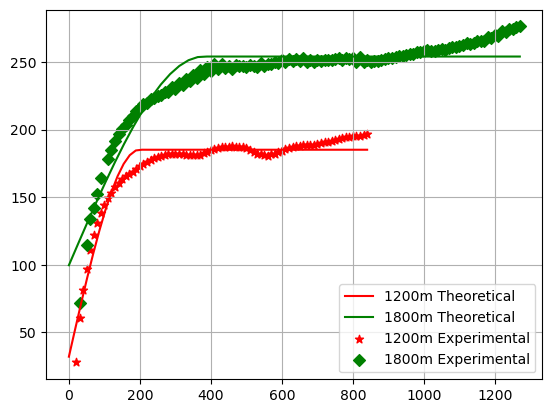

In [149]:
# Get the theoretical functions
def f_1200(x):
   return V_1200.fitted_model(x)
def f_1800(x):
   return V_1800.fitted_model(x)
# Create cubic interpolation model in order to make curved plot (otherwise it will be ugly af)
cubic_model_1200 = interp1d(np.concatenate((np.array([0]),bin_1200)), f_1200(np.concatenate((np.array([0]),bin_1200)),), kind = "cubic")
cubic_model_1800 = interp1d(np.concatenate((np.array([0]),bin_1800)), f_1800(np.concatenate((np.array([0]),bin_1800)),), kind = "cubic")
x_1200 = np.linspace(0,bin_1200[-1])
x_1800 = np.linspace(0,bin_1800[-1])
# Plot! 
plt.plot(x_1200, cubic_model_1200(x_1200),label = '1200m Theoretical', color = 'Red')
plt.plot(x_1800, cubic_model_1800(x_1800), label = '1800m Theoretical', color = 'Green')
plt.scatter(V_1200.get_empirical()[0],V_1200.get_empirical()[1], color = 'Red', label = '1200m Experimental', marker = '*')
plt.scatter(V_1800.get_empirical()[0],V_1800.get_empirical()[1], color = 'Green', label = '1800m Experimental', marker = 'D')
plt.legend()
plt.grid()

### Variogram Parameters

In [150]:
range_1200 = V_1200.parameters[0]
sill_1200 = V_1200.parameters[1] + V_1200.parameters[2]
nugget_1200 = V_1200.parameters[2]
range_1800 = V_1800.parameters[0]
sill_1800 = V_1800.parameters[1] + V_1800.parameters[2]
nugget_1800 = V_1800.parameters[2]
print("1200m Range: " + str(range_1200) + "; Sill: " + str(sill_1200) + "; Nugget: " + str(nugget_1200))
print("1800m Range: " + str(range_1800) + "; Sill: " + str(sill_1800) + "; Nugget: " + str(nugget_1800))

1200m Range: 198.24557984681613; Sill: 185.136815813907; Nugget: 32.07824834237741
1800m Range: 378.66453376977074; Sill: 254.06799249467872; Nugget: 99.7288695911247


## Roman Metrics

### Rcv (Coefficient of Variation)

In [151]:
CV_1200 = np.std(band_1200) / np.mean(band_1200)
CV_1800 = np.std(band_1800) / np.mean(band_1800)
Rcv_1200 = (CV_1800 - CV_1200) / CV_1200
Rcv_1200

0.25555605757158906

### RAW Score

In [152]:
RAW_1200 = (abs(2 * Rcv_1200)) ** (-1)
RAW_1200

1.956517895726008

### Rse (Scale Requirement)

In [153]:
Rse_1200 = math.exp(-((g / range_1200) ** 2 + (g / range_1800) ** 2) ** (1/2))
Rse_1200

0.9738161101205275

### Rst (Spatial Correlation)

In [154]:
# Get the index of the range in the bin
for i in range(len(V_1200.bins)):
    if range_1200 >= V_1200.bins[i] and range_1200 <= V_1200.bins[i+1]:
        index_1200 = i + 1
estimator_Range_1200 = V_1200.experimental[index_1200]
print(f"The range {(range_1200)} falls in {V_1200.bins[index_1200 - 1]} and {V_1200.bins[index_1200]}, whose value is {estimator_Range_1200}")
for i in range(len(V_1800.bins)):
    if range_1800 >= V_1800.bins[i] and range_1800 <= V_1800.bins[i+1]:
        index_1800 = i + 1
estimator_Range_1800 = V_1800.experimental[index_1800]
print(f"The range {(range_1800)} falls in {V_1800.bins[index_1800 - 1]} and {V_1800.bins[index_1800]}, whose value is {estimator_Range_1800}")

The range 198.24557984681613 falls in 190.0 and 200.0, whose value is 172.8973897839983
The range 378.66453376977074 falls in 370.0 and 380.0, whose value is 241.0227517290299


In [155]:
ST_1200 = (estimator_Range_1200 - nugget_1200) / estimator_Range_1200
ST_1800 = (estimator_Range_1800 - nugget_1800) / estimator_Range_1800
Rst_1200 = (ST_1800 - ST_1200) / ST_1200
Rst_1200

-0.28023278309021166

### Rsv Structural Variability

In [156]:
def f_1200_SV(x):
    return (V_1200.fitted_model(x) - nugget_1200) / sill_1200
def f_1800_SV(x):
    return (V_1800.fitted_model(x) - nugget_1800) / sill_1800
SV_1200 = quad(f_1200_SV, 0, range_1200)[0]
SV_1800 = quad(f_1800_SV, 0, range_1800)[0]
Rsv_1200 = (SV_1800 - SV_1200) / SV_1200
Rsv_1200

0.4034997351213353

### ST Score

In [157]:
ST_Score_1200 = (abs(Rcv_1200) / 3 + abs(Rst_1200) / 3 + abs(Rsv_1200) / 3 +Rse_1200) ** (-1)
ST_Score_1200

0.7770537265114398

# Final Results

In [158]:
df = pd.DataFrame({
    "Site": site_Name,
    "Distance": ['100m', '300m', '900m', '1200m'],
    "Range": [range_100, range_300, range_900, range_1200],
    "Sill": [sill_100, sill_300, sill_900, sill_1200],
    "Nugget": [nugget_100, nugget_300, nugget_900, nugget_1200],
    "Rcv": [Rcv_100, Rcv_300, Rcv_900, Rcv_1200],
    "Rse": [Rse_100, Rse_300, Rse_900, Rse_1200],
    "Rst": [Rst_100, Rst_300, Rst_900, Rst_1200],
    "Rsv": [Rsv_100, Rsv_300, Rsv_900, Rsv_1200],
    "RAW Score": [RAW_100, RAW_300, RAW_900, RAW_1200],
    "ST Score": [ST_Score_100, ST_Score_300, ST_Score_900, ST_Score_1200]
})
df

,Site,Distance,Range,Sill,Nugget,Rcv,Rse,Rst,Rsv,RAW Score,ST Score
0,Monte Bondone,100m,70.000000,21.402893,6.101917e-15,0.088601,0.912508,-7.993606e-15,0.059066,5.643296,1.039793
1,Monte Bondone,300m,167.987442,104.183407,2.303115e+01,0.141708,0.937176,2.880248e-01,-0.392839,3.528377,0.825514
2,Monte Bondone,900m,156.802501,170.867567,1.764863e+01,0.141587,0.964968,-1.218749e-01,0.328726,3.531409,0.860316
3,Monte Bondone,1200m,198.245580,185.136816,3.207825e+01,0.255556,0.973816,-2.802328e-01,0.403500,1.956518,0.777054


In [159]:
df.to_csv(cwd_Images_Processed + "\\" + site_Name + "\\Result.csv", index = False)

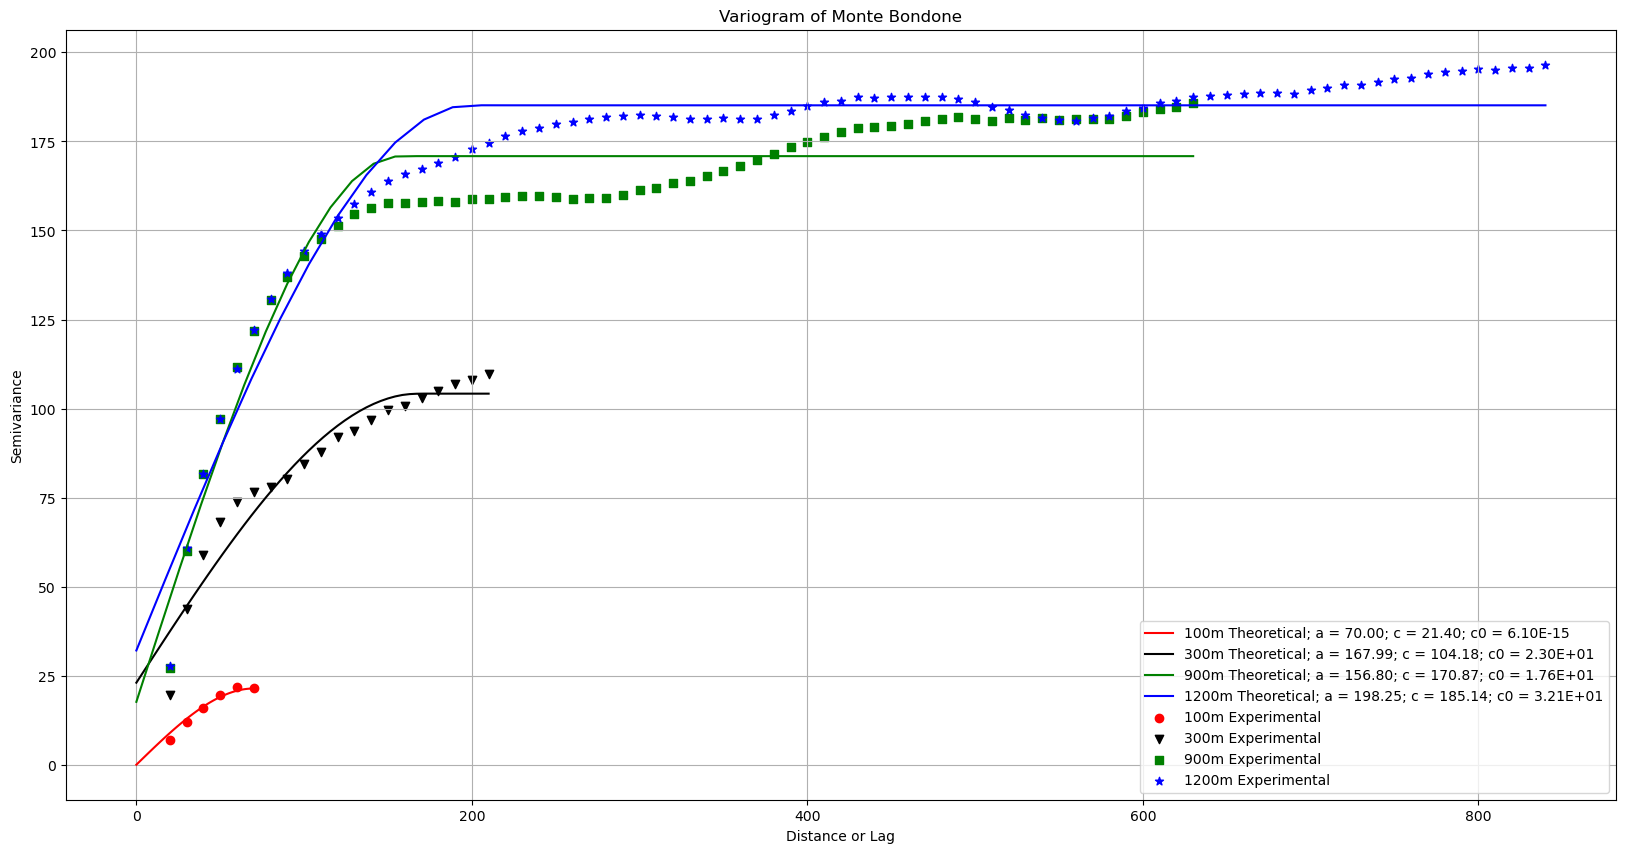

In [160]:
# Plot! 
plt.figure(figsize = (20,10))
plt.plot(x_100, cubic_model_100(x_100), label = f'100m Theoretical; a = {range_100:.2F}; c = {sill_100:.2F}; c0 = {nugget_100:.2E}', color = 'Red', linestyle = '-')
plt.plot(x_300, cubic_model_300(x_300), label = f'300m Theoretical; a = {range_300:.2F}; c = {sill_300:.2F}; c0 = {nugget_300:.2E}', color = 'Black', linestyle = '-')
plt.plot(x_900, cubic_model_900(x_900), label = f'900m Theoretical; a = {range_900:.2F}; c = {sill_900:.2F}; c0 = {nugget_900:.2E}', color = 'Green', linestyle = '-')
plt.plot(x_1200, cubic_model_1200(x_1200), label = f'1200m Theoretical; a = {range_1200:.2F}; c = {sill_1200:.2F}; c0 = {nugget_1200:.2E}', color = 'Blue', linestyle = '-')
plt.scatter(V_100.get_empirical()[0],V_100.get_empirical()[1], color = 'Red', label = '100m Experimental', marker = 'o')
plt.scatter(V_300.get_empirical()[0],V_300.get_empirical()[1], color = 'Black', label = '300m Experimental', marker = 'v')
plt.scatter(V_900.get_empirical()[0],V_900.get_empirical()[1], color = 'Green', label = '900m Experimental', marker = 's')
plt.scatter(V_1200.get_empirical()[0],V_1200.get_empirical()[1], color = 'Blue', label = '1200m Experimental', marker = '*')
plt.title("Variogram of " + site_Name)
plt.xlabel("Distance or Lag")
plt.ylabel("Semivariance")
plt.legend()
plt.grid()
plt.savefig(cwd_Images_Processed + "\\" + site_Name + "\\Result.png")